In [157]:
from dataclasses import dataclass
import numpy as np
from scipy.integrate import solve_ivp, quad
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt

In [187]:
def system(M, C, K, x0, xd0):
    M, C, K = np.array(M), np.array(C), np.array(K)

    Msi = np.linalg.inv(np.sqrt(M))

    w, V = np.linalg.eig(Msi @ K @ Msi)
    idx = np.argsort(np.abs(w))       # ordena pelos autovalores (aqui pelo módulo)
    V_sorted = V[:, idx]           # colunas reordenadas

    P = V_sorted
    
    r0, rd0 = np.sqrt(M) @ P.T @ x0, np.sqrt(M) @ P.T @ xd0

    sys = {
        'Msi': Msi,
        'P': P,
        'Cmod': P.T @ Msi @ C @ Msi @ P,
        'Kmod': P.T @ Msi @ K @ Msi @ P,
        'Fmod': P.T @ Msi,
        'r0': r0,
        'rd0': rd0
    }
    return sys

In [4]:
def system_mod(sys):
    Ms = np.sqrt(sys["M"])
    sysMod = {
        "Ctilde": np.linalg.inv(Ms) @ sys["C"] @ np.linalg.inv(Ms),
        "Ktilde": np.linalg.inv(Ms) @ sys["K"] @ np.linalg.inv(Ms)
    }

    w, V = np.linalg.eig(sysMod["Ktilde"])        # w = autovalores (possivelmente complexos), V = autovetores em colunas
    idx = np.argsort(np.abs(w))       # ordena pelos autovalores (aqui pelo módulo)
    V_sorted = V[:, idx]           # colunas reordenadas
    w_sorted = w[idx]              # autovalores reordenados
    sysMod["lambdas"] = np.sqrt(w_sorted) # frequências naturais (autovalores naturais)

    P = V_sorted
    sysMod["P"] = P

    S = np.linalg.inv(Ms) @ P
    sysMod["S"] = S

    sysMod["r0"] = np.linalg.inv(S) @ sys["x0"]
    sysMod["rd0"] = np.linalg.inv(S) @ sys["xd0"]

    sysMod["Mmod"] = np.identity(len(sys["M"]))
    sysMod["Cmod"] = P.T @ sysMod["Ctilde"]
    sysMod["Kmod"] = P.T @ sysMod["Ktilde"]

    print('------------------------')
    print('Mmod', sysMod['Mmod'].shape)
    print('Cmod', sysMod['Cmod'].shape)
    print('Kmod', sysMod['Kmod'].shape)
    print('P.T', P.T.shape)
    print('Ms-1', np.linalg.inv(Ms).shape)
    print('sys[F]', sys['F'].shape)
    print('------------------------')

    sysMod["Fmod"] = P.T @ np.linalg.inv(Ms) @ sys['F']

    return sysMod

In [28]:
def fSS(t, r, c, k, F):
    u1, u2 = r
    u1d = u2
    u2d = -c*u2 - k*u1 + F(t)
    return [u1d, u2d]

In [117]:
def solve_mdof_num(t_eval, sys, f, method="RK45", rtol=1e-8, atol=1e-10):
    Cmod, Kmod, Fmod, r0, rd0 = sys['Cmod'], sys['Kmod'], sys['Fmod'], sys['r0'], sys['rd0']
    n = Cmod.shape[0]

    r, rd, rdd = [], [], []
    t0, tf = float(t_eval[0]), float(t_eval[-1])
    for i in range(n):
        y0 = np.hstack([r0[i], rd0[i]])
        F = lambda t: Fmod[i][i]*f[i](t,0)
        c = Cmod[i][i]
        k = Kmod[i][i]
        sol = solve_ivp(
            fSS,
            (t0, tf),
            y0,
            t_eval=t_eval,
            args=(c, k, F)
        )
        r.append(sol['y'][0])
        rd.append(sol['y'][1])
        rdd.append( -c*sol['y'][1] - k*sol['y'][0] + F(t_eval))
    
    r = np.array(r)
    rd = np.array(rd)
    rdd = np.array(rdd)

    x = sys['Msi'] @ sys['P'] @ r
    v = sys['Msi'] @ sys['P'] @ rd
    a = sys['Msi'] @ sys['P'] @ rdd

    return x, v, a

In [165]:
def solve_mdof_analytic_mod(t_eval, sys, f, integration):
    Cmod, Kmod, Fmod, r0, rd0 = sys['Cmod'], sys['Kmod'], sys['Fmod'], sys['r0'], sys['rd0']
    n = Cmod.shape[0]
    t0 = float(t_eval[0])

    r_list, v_list, a_list = [], [], []

    for i in range(n):
        r0_i  = float(r0[i]); v0_i = float(rd0[i])

        # força modal do modo i (B = I no seu caso)
        Fi = lambda t: np.dot(Fmod[i, :],
                      np.array([fj(t, 0) for fj in f], dtype=float))

        omega = float(np.sqrt(Kmod[i, i]))
        zeta  = float(Cmod[i, i] / (2.0*omega))
        alpha = zeta*omega

        # --- escolher expressões conforme o regime ---
        if zeta < 1:
            omegad = omega*np.sqrt(1 - zeta**2)
            # homogênea
            rh  = np.exp(-alpha*t_eval)*( r0_i*np.cos(omegad*t_eval)
                   + (v0_i + alpha*r0_i)/omegad * np.sin(omegad*t_eval) )
            rdh = np.exp(-alpha*t_eval)*( 
                   -alpha*( r0_i*np.cos(omegad*t_eval) + (v0_i + alpha*r0_i)/omegad*np.sin(omegad*t_eval) )
                   - r0_i*omegad*np.sin(omegad*t_eval) + (v0_i + alpha*r0_i)*np.cos(omegad*t_eval) )
            # kernels
            h    = lambda dt: (np.exp(-alpha*dt)*np.sin(omegad*dt)/omegad) if dt>=0 else 0.0
            hdot = lambda dt: (np.exp(-alpha*dt)*(np.cos(omegad*dt) - (alpha/omegad)*np.sin(omegad*dt))) if dt>=0 else 0.0

        elif zeta > 1:
            s  = np.sqrt(zeta**2 - 1.0)
            r1 = -omega*(zeta - s); r2 = -omega*(zeta + s)
            C1 = (v0_i - r2*r0_i)/(r1 - r2); C2 = (r1*r0_i - v0_i)/(r1 - r2)
            rh  = C1*np.exp(r1*t_eval) + C2*np.exp(r2*t_eval)
            rdh = C1*r1*np.exp(r1*t_eval) + C2*r2*np.exp(r2*t_eval)
            h    = lambda dt: ((np.exp(r1*dt) - np.exp(r2*dt))/(r1 - r2)) if dt>=0 else 0.0
            hdot = lambda dt: ((r1*np.exp(r1*dt) - r2*np.exp(r2*dt))/(r1 - r2)) if dt>=0 else 0.0

        else:  # crítico
            rh  = np.exp(-omega*t_eval)*( r0_i + (v0_i + omega*r0_i)*t_eval )
            rdh = np.exp(-omega*t_eval)*( (v0_i + omega*r0_i) - omega*(r0_i + (v0_i + omega*r0_i)*t_eval) )
            h    = lambda dt: (dt*np.exp(-omega*dt)) if dt>=0 else 0.0
            hdot = lambda dt: (np.exp(-omega*dt)*(1 - omega*dt)) if dt>=0 else 0.0

        # --- convoluções ---
        if integration=='convolucao':
            dt = t_eval[1] - t_eval[0]
            F_s = np.array([Fi(t) for t in t_eval])

            h_s    = np.array([h(t)    for t in t_eval])
            hdot_s = np.array([hdot(t) for t in t_eval])

            rp = dt * fftconvolve(h_s,    F_s, mode="full")[:len(t_eval)]
            vp = dt * fftconvolve(hdot_s, F_s, mode="full")[:len(t_eval)]
        elif integration=='integral':
            rp  = np.empty_like(t_eval); vp = np.empty_like(t_eval)
            for k, tk in enumerate(t_eval):
                integ_r  = lambda tau: h(tk - tau)    * Fi(tau)
                integ_v  = lambda tau: hdot(tk - tau) * Fi(tau)
                rp[k] = quad(integ_r, t0, float(tk), limit=200)[0]
                vp[k] = quad(integ_v, t0, float(tk), limit=200)[0]

        r = rh + rp
        v = rdh + vp
        # aceleração analítica via EDO (evita ḧ):  r̈ = -2ζω ṙ - ω² r + F(t)
        Fe = np.array([Fi(tk) for tk in t_eval], dtype=float)
        a = -2.0*zeta*omega*v - (omega**2)*r + Fe

        r_list.append(r); v_list.append(v); a_list.append(a)

    r  = np.vstack(r_list)   # (n, len(t))
    v  = np.vstack(v_list)
    a  = np.vstack(a_list)

    # volta ao espaço físico
    x = sys['Msi'] @ sys['P'] @ r
    v_phys = sys['Msi'] @ sys['P'] @ v
    a_phys = sys['Msi'] @ sys['P'] @ a

    return x, v_phys, a_phys


In [184]:
# Exemplo MatLab Nabarrete

M = [[100]]
C = [[100]]
K = [[910]]
x0 = [[0.001]]
xd0 = [[0.02]]

t = np.arange(0, 20, 0.001) # deixaremos a escolhe do tempo assim, por enquanto
f = [lambda t, s: 10*np.cos(3*t)]

sys = system(M, C, K, x0, xd0)

x_num, v_num, a_num = solve_mdof_num(t, sys, f)
x_analityc, v_analityc, a_analityc = solve_mdof_analytic_mod(t, sys, f, integration='convolucao')

C:\Users\ymarc\AppData\Local\Temp\ipykernel_23548\2886369549.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r0_i  = float(r0[i]); v0_i = float(rd0[i])


In [179]:
# Exemplo 4.9.2 Inman

M = [[1, 0], [0, 4]]
C = [[0,0], [0,0]]
K = [[12, -2], [-2, 12]]
x0 = [[1], [1]]
xd0 = [[0], [1]]

dt = 0.01
t = np.arange(0, 20, dt) # deixaremos a escolhe do tempo assim, por enquanto
f = [lambda t, s: (1.0/(np.sqrt(2*np.pi)*dt)) * np.exp(-t**2/(2*dt**2)),
     lambda t, s: 0]

sys = system(M, C, K, x0, xd0)
x_num, v_num, a_num = solve_mdof_num(t, sys, f)
x_analityc, v_analityc, a_analityc = solve_mdof_analytic_mod(t, sys, f, integration='convolucao')

C:\Users\ymarc\AppData\Local\Temp\ipykernel_23548\2886369549.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r0_i  = float(r0[i]); v0_i = float(rd0[i])


In [182]:
# Exemplo 4.10.3 Inman

M = [[2, 0], [0, 1]]
C = [[0.3, -0.05], [-0.05, 0.05]]
K = [[3, -1], [-1, 1]]
x0 = [[0], [-0.1]]
xd0 = [[0], [0]]

dt = 0.001
t = np.arange(0, 30, dt) # deixaremos a escolhe do tempo assim, por enquanto
f = [lambda t, s: 0,
     lambda t, s: np.where((t >= 1) & (t < 1.1), 1.0, 0.0)]

sys = system(M, C, K, x0, xd0)

x_num, v_num, a_num = solve_mdof_num(t, sys, f)
x_analityc, v_analityc, a_analityc = solve_mdof_analytic_mod(t, sys, f, integration='convolucao')

C:\Users\ymarc\AppData\Local\Temp\ipykernel_23548\2886369549.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r0_i  = float(r0[i]); v0_i = float(rd0[i])


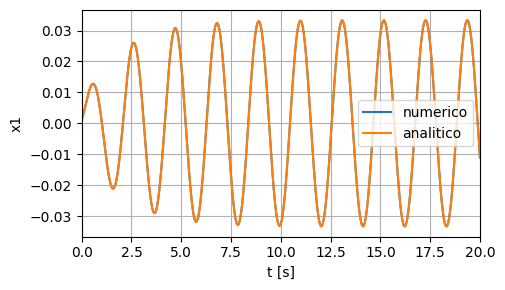

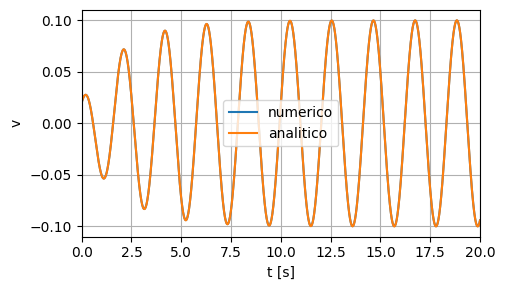

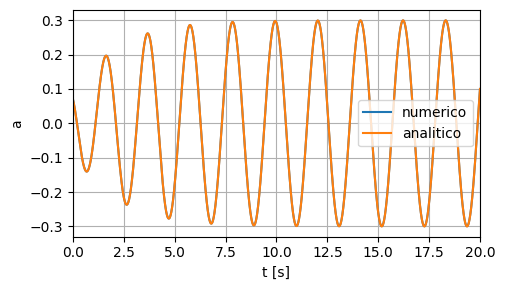

In [185]:
plt.figure(figsize=(5,3))
plt.plot(t,     x_num[0], '-',      label='numerico')
plt.plot(t,     x_analityc[0], '-',      label='analitico')
plt.xlabel('t [s]'); plt.ylabel('x1'); plt.grid(True); plt.legend(); plt.tight_layout()
plt.xlim(0,20)

plt.figure(figsize=(5,3))
plt.plot(t,     v_num[0], '-',      label='numerico')
plt.plot(t,     v_analityc[0], '-',      label='analitico')
plt.xlabel('t [s]'); plt.ylabel('v'); plt.grid(True); plt.legend(); plt.tight_layout()
plt.xlim(0,20)
plt.show()

plt.figure(figsize=(5,3))
plt.plot(t,     a_num[0], '-',      label='numerico')
plt.plot(t,     a_analityc[0], '-',      label='analitico')
plt.xlabel('t [s]'); plt.ylabel('a'); plt.grid(True); plt.legend(); plt.tight_layout()
plt.xlim(0,20)
plt.show()

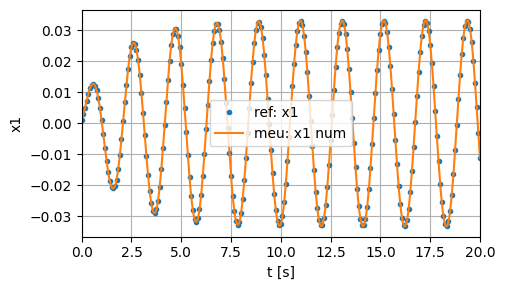

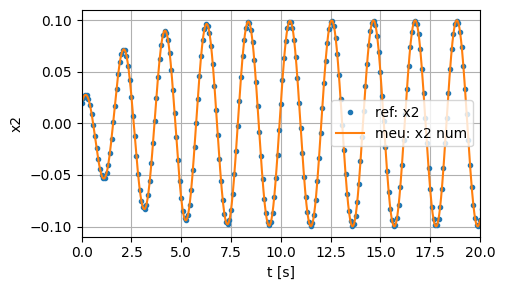

In [186]:
# 1) Ler referência
ref = np.loadtxt('resultado_numerico.txt')   # colunas: t, x1_ref, x2_ref
t_ref, x1_ref, x2_ref = ref.T

# 5) Plots
plt.figure(figsize=(5,3))
plt.plot(t_ref, x1_ref, 'o', ms=3, label='ref: x1')
plt.plot(t,     x_num[0], '-',      label='meu: x1 num')
plt.xlabel('t [s]'); plt.ylabel('x1'); plt.grid(True); plt.legend(); plt.tight_layout()
plt.xlim(0,20)

plt.figure(figsize=(5,3))
plt.plot(t_ref, x2_ref, 'o', ms=3, label='ref: x2')
plt.plot(t,     v_num[0], '-',      label='meu: x2 num')
plt.xlabel('t [s]'); plt.ylabel('x2'); plt.grid(True); plt.legend(); plt.tight_layout()
plt.xlim(0,20)
plt.show()

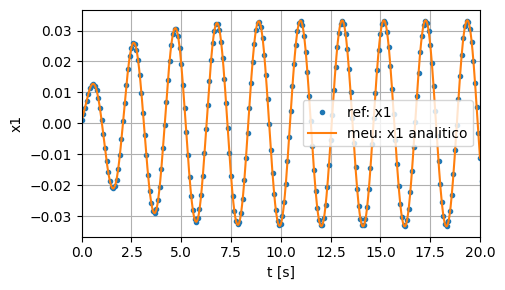

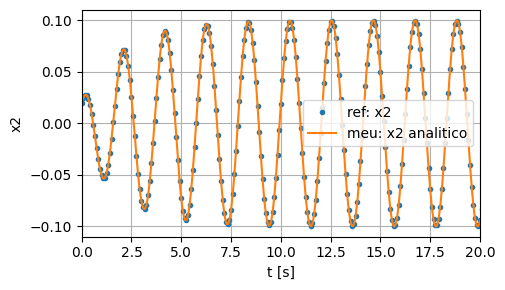

In [177]:
# 1) Ler referência
ref = np.loadtxt('resultado_numerico.txt')   # colunas: t, x1_ref, x2_ref
t_ref, x1_ref, x2_ref = ref.T

# 5) Plots
plt.figure(figsize=(5,3))
plt.plot(t_ref, x1_ref, 'o', ms=3, label='ref: x1')
plt.plot(t,     x_analityc[0], '-',      label='meu: x1 analitico')
plt.xlabel('t [s]'); plt.ylabel('x1'); plt.grid(True); plt.legend(); plt.tight_layout()
plt.xlim(0,20)

plt.figure(figsize=(5,3))
plt.plot(t_ref, x2_ref, 'o', ms=3, label='ref: x2')
plt.plot(t,     v_analityc[0], '-',      label='meu: x2 analitico')
plt.xlabel('t [s]'); plt.ylabel('x2'); plt.grid(True); plt.legend(); plt.tight_layout()
plt.xlim(0,20)
plt.show()